# Example Case using RewardingFrozenLake

Below is an example of how to initialize the RewardingFrozenLake environment and solve/compare with multiple solvers.

## Boilerplate


If you're playing with things under the hood as you run these, autoreload is always useful...

In [1]:
%load_ext autoreload

%autoreload 2

If necessary, add directory containing lrl to path (workaround for if lrl is not installed as a package)

In [2]:
import sys

# Path to directory containing lrl
sys.path.append('../') 

In [3]:
from lrl import environments, solvers
from lrl.utils import plotting

import matplotlib.pyplot as plt

Logging is used throughout lrl for basic info and debugging. 

In [4]:
import logging
logging.basicConfig(format='%(asctime)s - %(name)s - %(funcName)s - %(levelname)s - %(message)s',
                    level=logging.INFO, datefmt='%H:%M:%S')
logger = logging.getLogger(__name__)

## Initialize an Environment

Initialize an 8x8 Frozen Lake (4x4 and other shapes also available - see code and docs)

In [5]:
lake = environments.frozen_lake.RewardingFrozenLakeEnv(map_name='8x8', is_slippery=True)

Take a look at the env using plot_env

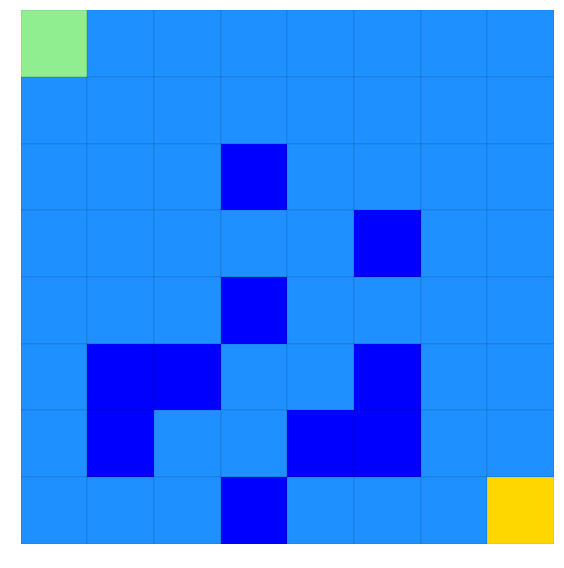

In [6]:
plotting.plot_env(env=lake)

Ice is light blue - holes are dark blue.  Make it from green to yellow without hitting any holes!

## Solve with Value Iteration and Interrogate Solution

First, with Value Iteration

In [7]:
lake_vi = solvers.ValueIteration(env=lake)
lake_vi.iterate_to_convergence()

16:32:22 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Solver iterating to convergence (Max delta in value function < 0.001 or iters>500)
16:32:22 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Solver converged to solution in 32 iterations


And we can then score our solution by running it multiple times through the environment

In [8]:
scoring_data = lake_vi.score_policy(iters=500)

score_policy returns a EpisodeStatistics object that contains details from each episode taken during the scoring, plus aggregate scores.  Easiest way to interact with it is grabbing data as a dataframe

In [9]:
print(f'type(scoring_data) = {type(scoring_data)}')
scoring_data_df = scoring_data.to_dataframe(include_episodes=True)
scoring_data_df.head(3)

type(scoring_data) = <class 'lrl.data_stores.data_stores.EpisodeStatistics'>


,episode_index,reward,steps,terminal,reward_mean,reward_median,reward_std,reward_min,reward_max,steps_mean,steps_median,steps_std,steps_min,steps_max,terminal_fraction,episodes
0,0,0.87,15,True,0.870000,0.87,0.000000,0.87,0.87,15.000000,15.0,0.000000,15,15,1.0,"[0, 1, 2, 3, 4, 5, 6, 7, 15, 23, 31, 39, 47, 5..."
1,1,0.81,21,True,0.840000,0.84,0.030000,0.81,0.87,18.000000,18.0,3.000000,15,21,1.0,"[0, 0, 1, 2, 10, 11, 3, 4, 12, 13, 14, 22, 23,..."
2,2,0.85,17,True,0.843333,0.85,0.024944,0.81,0.87,17.666667,17.0,2.494438,15,21,1.0,"[0, 1, 2, 3, 4, 12, 13, 14, 22, 23, 31, 30, 38..."


In [10]:
scoring_data_df.tail(3)

,episode_index,reward,steps,terminal,reward_mean,reward_median,reward_std,reward_min,reward_max,steps_mean,steps_median,steps_std,steps_min,steps_max,terminal_fraction,episodes
497,497,0.82,20,True,0.805843,0.81,0.045295,0.58,0.87,21.415663,21.0,4.529457,15,44,1.0,"[0, 1, 2, 3, 3, 4, 12, 13, 14, 22, 14, 22, 30,..."
498,498,0.84,18,True,0.805912,0.81,0.045275,0.58,0.87,21.408818,21.0,4.527494,15,44,1.0,"[0, 1, 2, 3, 4, 5, 6, 14, 22, 30, 31, 39, 39, ..."
499,499,0.81,21,True,0.805920,0.81,0.045230,0.58,0.87,21.408000,21.0,4.523001,15,44,1.0,"[0, 1, 2, 3, 4, 5, 6, 14, 22, 23, 31, 39, 39, ..."


Reward, Steps, and Terminal columns give data on that specific episode, whereas reward_mean, \_median, etc. columns give aggregate scores up until that walk.  For example:

In [11]:
print(f'The reward obtained in the 499th episode was {scoring_data_df.loc[499, "reward"]}')
print(f'The mean reward obtained in the 0-499th episode (inclusive) was {scoring_data_df.loc[499, "reward_mean"]}')

The reward obtained in the 499th episode was 0.8099999999999999
The mean reward obtained in the 0-499th episode (inclusive) was 0.80592


And we can access the actual episode path for each episode

In [12]:
print(f'Episode 0 (directly)          : {scoring_data.episodes[0]}')
print(f'Episode 0 (from the dataframe): {scoring_data_df.loc[0, "episodes"]}')

Episode 0 (directly)          : [0, 1, 2, 3, 4, 5, 6, 7, 15, 23, 31, 39, 47, 55, 63]
Episode 0 (from the dataframe): [0, 1, 2, 3, 4, 5, 6, 7, 15, 23, 31, 39, 47, 55, 63]


But note that the Frozen Lake indexes its states by an integer, not the (x, y) or (row, col) coordinates.  But we can get coordinates easily enough...

In [13]:
i = 0
print(f'Location index={i} is at (x, y) location {lake.index_to_state[i]} (where x=0 is left and y=0 is bot)')
loc = (0, 0)
print(f'And going the other way, location {loc} is index {lake.state_to_index[loc]}')

Location index=0 is at (x, y) location (0, 7) (where x=0 is left and y=0 is bot)
And going the other way, location (0, 0) is index 56


## Plotting Results

Plotting 100 randomly chosen episodes on the map, returned as a matplotlib axes, we get:

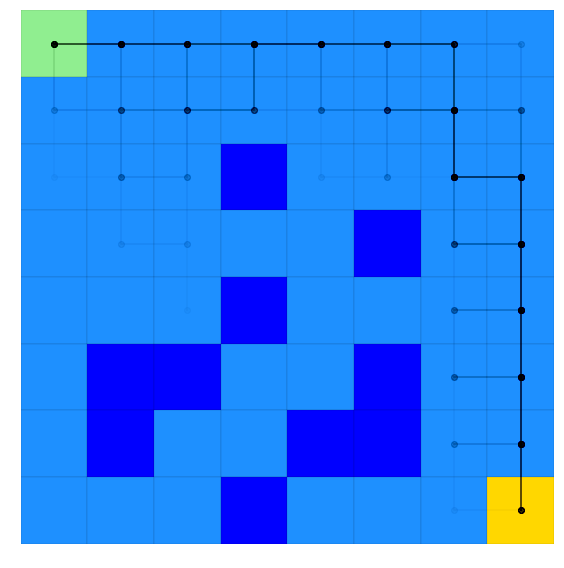

In [14]:
ax_episodes = plotting.plot_episodes(episodes=scoring_data.episodes, env=lake, max_episodes=100, )

Where we see our strategy tries to stay around the outside edge for the most part, but sometiems slips closer to the middle (although we never actually hit a hole!)

score_policy also lets us use hypothetical scenario, such as what if we started in a different starting location.  Let's try that by starting in the middle of some of the holes, plotting this new scenario in red.

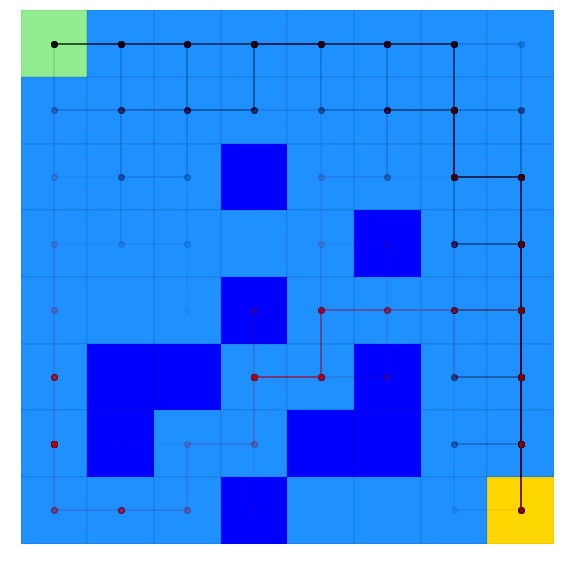

In [15]:
# Initial state is in (x, y) format
initial_state_tuple = (3, 2)
initial_state_index = lake.state_to_index[initial_state_tuple]
scoring_data_alternate = lake_vi.score_policy(iters=500, initial_state=initial_state_index)
ax_episodes_with_alternate = plotting.plot_episodes(env=lake, episodes=scoring_data_alternate.episodes, add_env_to_plot=False, 
                                                    color='r', ax=ax_episodes,
#                                                     savefig='my_figure_file',  # If you wanted the figure to save directly 
                                                                                 # to file, use savefig (used throughout 
                                                                                 # lrl's plotting scripts)
                                                    )

# Must get_figure because we're reusing the figure from above and jupyter wont automatically reshow it
ax_episodes_with_alternate.get_figure()

Where we can see the optimal policy sometimes manages to win, and sometimes just falls in a hole...

We can also look at the Value function and best policy for all states

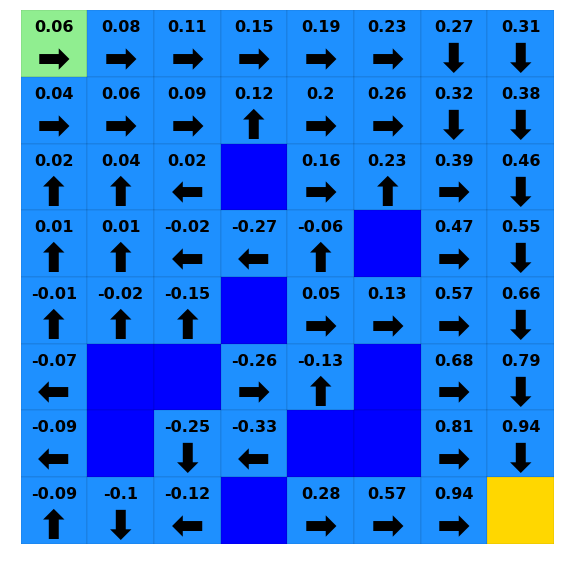

In [16]:
ax_results = plotting.plot_solver_results(env=lake, solver=lake_vi)

One thing we might want to do with this solution is see how the policy evolved over time.  Policies and value (or Q) functions are saved in a dict-like data store that maintains both current value and the history of that value over time.  For example, lets look at the value for index 0 (bottom left)

We can grab the most recent value at location 0 by:

In [17]:
iteration = 31  # Could also be -1 to get the last item, like normal list syntax
lake_vi.value.get_value_at_timepoint(key=0, timepoint=iteration)

0.05538280537023101

And we can also get the history of all values for location 0

In [18]:
lake_vi.value.get_value_history(0)

[(0, -0.009999999999999998),
 (1, -0.018999999999999996),
 (2, -0.0271),
 (3, -0.03439),
 (4, -0.040951),
 (5, -0.046855900000000006),
 (6, -0.05217031000000001),
 (7, -0.056953279000000016),
 (8, -0.06125795110000003),
 (9, -0.06513215599000002),
 (10, -0.06861894039100003),
 (11, -0.07175704635190003),
 (12, -0.07458134171671002),
 (13, -0.06620112263383392),
 (14, -0.05606391032872242),
 (15, -0.03814365080870915),
 (16, -0.02193630467499485),
 (17, -0.004533717206715425),
 (18, 0.009321649875289119),
 (19, 0.021602026276737636),
 (20, 0.030685599534352126),
 (21, 0.037967128156801665),
 (22, 0.04311442211812146),
 (23, 0.04700668910612634),
 (24, 0.04968251379686211),
 (25, 0.05163476331362879),
 (26, 0.0529522810474764),
 (27, 0.05389380710935053),
 (28, 0.054507344360609306),
 (29, 0.05495173816104297),
 (30, 0.05519127451645814),
 (31, 0.05538280537023101)]

We see that the value changes each iteration, so we have one entry per iteration.  But, if we look at policy, we see a more efficient storage:

In [19]:
iteration = 31  # Could also be -1 to get the last item, like normal list syntax
print(f'Most recent policy at key=0: {lake_vi.policy.get_value_at_timepoint(key=0, timepoint=iteration)}')
print('History of all changes:')
lake_vi.policy.get_value_history(0)

Most recent policy at key=0: 2
History of all changes:


[(0, 0), (13, 2)]

Where we see policy was initialized at iteration 0 (to value of 0), and changed at iteration 13 to a value of 2.  What is action 2?

In [20]:
action = 2
print(f'Using lake environment, action {action} is {lake.action_as_char[2]}')

Using lake environment, action 2 is ➡


We can also access the entire policy at a given timepoint by grabbing it from the data store as a dict:

In [21]:
p_12 = lake_vi.policy.to_dict(timepoint=12)
p_13 = lake_vi.policy.to_dict(timepoint=13)
i = 0
print(f'policy at index {i} was {lake.action_as_char[p_12[i]]} at iteration 12 and {lake.action_as_char[p_13[i]]} at iteration 13')


policy at index 0 was ⬅ at iteration 12 and ➡ at iteration 13


And even plot everything over time...

Iteration 0


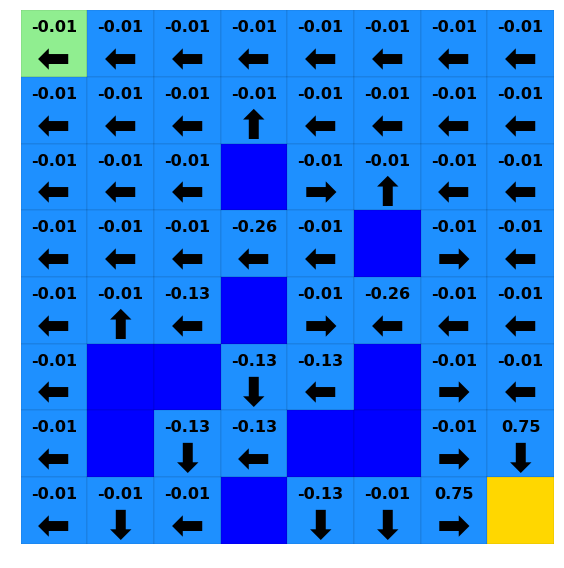

Iteration 10


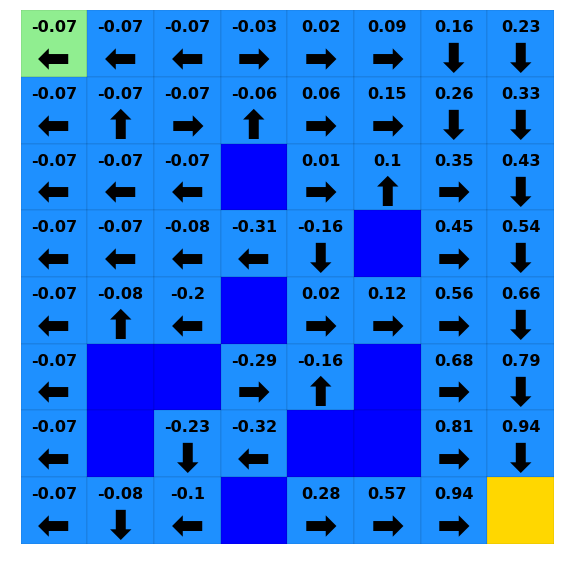

Iteration 20


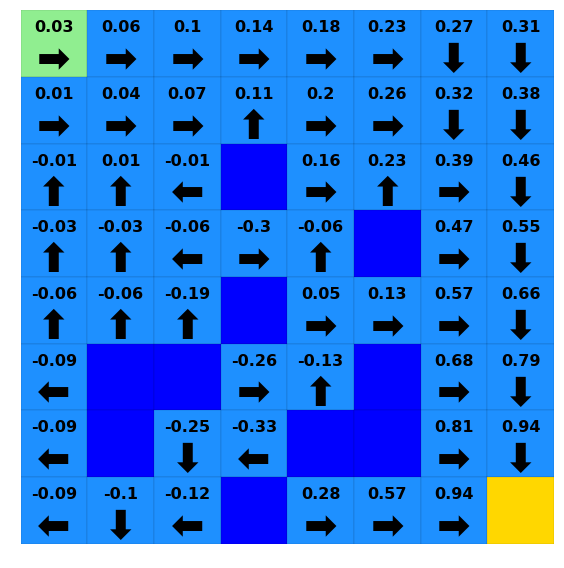

Iteration 30


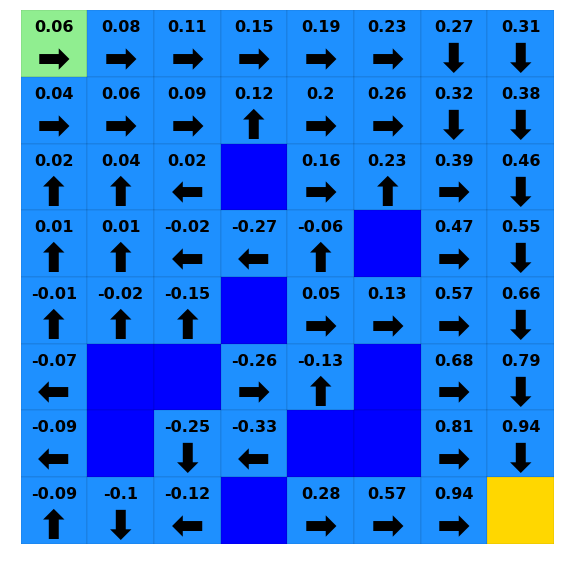

In [22]:
for i in [0, 10, 20, 30]:
    print(f"Iteration {i}")
    ax = plotting.plot_solver_results(env=lake, 
                                     policy=lake_vi.policy.to_dict(timepoint=i),
                                     value=lake_vi.value.to_dict(timepoint=i),
                                     )
    plt.show()

## Solving with Policy Iteration and Comparing to Value Iteration

We can also use other solvers

In [23]:
lake_pi = solvers.PolicyIteration(env=lake)
lake_pi.iterate_to_convergence()

16:32:36 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Solver iterating to convergence (1 iteration without change in policy or iters>500)
16:32:36 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Solver converged to solution in 10 iterations


We can look at how PI and VI converged relative to each other, comparing the maximum change in value function for each iteration

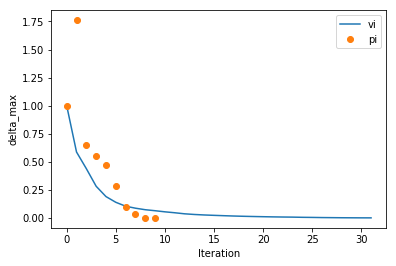

In [24]:
# (these are simple convenience functions for plotting, basically just recipes.  See the plotting API)
# We can pass the solver..
ax = plotting.plot_solver_convergence(lake_vi, label='vi')

# Or going a little deeper into the API, with style being passed to matplotlib's plot function...
ax = plotting.plot_solver_convergence_from_df(lake_pi.iteration_data.to_dataframe(), y='delta_max', x='iteration', ax=ax, label='pi', ls='', marker='o')

ax.legend()

And looking at policy changes per iteration

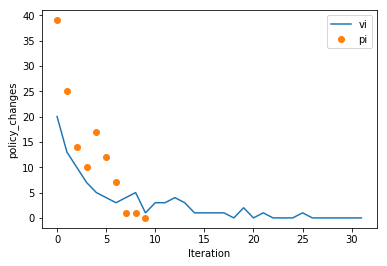

In [25]:
# (these are simple convenience functions for plotting, basically just recipes.  See the plotting API)
# We can pass the solver..
ax = plotting.plot_solver_convergence(lake_vi, y='policy_changes', label='vi')

# Or going a little deeper into the API...
ax = plotting.plot_solver_convergence_from_df(lake_pi.iteration_data.to_dataframe(), y='policy_changes', x='iteration', ax=ax, label='pi', ls='', marker='o')

ax.legend()

So we can see PI accomplishes a little more per iteration.  But, is it faster?  Let's look at time per iteration

Total solution time for Value Iteration (excludes any scoring time):  0.05s
Total solution time for Policy Iteration (excludes any scoring time): 0.20s


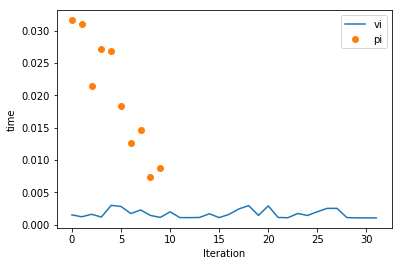

In [26]:
# (these are simple convenience functions for plotting, basically just recipes.  See the plotting API)
# We can pass the solver..
ax = plotting.plot_solver_convergence(lake_vi, y='time', label='vi')

# Or going a little deeper into the API...
ax = plotting.plot_solver_convergence_from_df(lake_pi.iteration_data.to_dataframe(), y='time', x='iteration', ax=ax, label='pi', ls='', marker='o')

ax.legend()

print(f'Total solution time for Value Iteration (excludes any scoring time):  {lake_vi.iteration_data.to_dataframe().loc[:, "time"].sum():.2f}s')
print(f'Total solution time for Policy Iteration (excludes any scoring time): {lake_pi.iteration_data.to_dataframe().loc[:, "time"].sum():.2f}s')

## Solve with Q-Learning

We can also use QLearning, although it needs a few parameters

In [27]:
# Let's be explicit with our QLearning settings for alpha and epsilon
alpha = 0.1  # Constant alpha during learning

# Decay function for epsilon (see QLearning() and decay_functions() in documentation for syntax)
# Decay epsilon linearly from 0.2 at timestep (iteration) 0 to 0.05 at timestep 1500, 
# keeping constant at 0.05 for ts>1500
epsilon = {
    'type': 'linear',
    'initial_value': 0.2, 
    'initial_timestep': 0,
    'final_value': 0.05, 
    'final_timestep': 1500
}

# Above PI/VI used the default gamma, but we will specify one here
gamma = 0.9

# Convergence is kinda tough to interpret automatically for Q-Learning.  One good way to monitor convergence is to
# evaluate how good the greedy policy at a given point in the solution is and decide if it is still improving.
# We can enable this with score_while_training (available for Value and Policy Iteration as well)
# NOTE: During scoring runs, the solver is acting greedily and NOT learning from the environment.  These are separate
#       runs solely used to estimate solution progress
# NOTE: Scoring every 50 iterations is probably a bit much, but used to show a nice plot below.  The default 500/500 
#       is probably a better general guidance
score_while_training = {
    'n_trains_per_eval': 50,  # Number of training episodes we run per attempt to score the greedy policy 
                               # (eg: Here we do a scoring run after every 500 training episodes, where training episodes
                               # are the usual epsilon-greedy exploration episodes)
    'n_evals': 250,  # Number of times we run through the env with the greedy policy whenever we score
}
# score_while_training = True  # This calls the default settings, which are also 500/500 like above

lake_ql = solvers.QLearning(env=lake, alpha=alpha, epsilon=epsilon, gamma=gamma,
                          max_iters=5000, score_while_training=score_while_training)

(note how long Q-Learning takes for this environment versus the planning algorithms)

In [28]:
lake_ql.iterate_to_convergence()

16:32:38 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Solver iterating to convergence (20 episodes with max delta in Q function < 0.1 or iters>5000)
16:32:38 - lrl.solvers.learners - iterate - INFO - Performing iteration (episode) 0 of Q-Learning
16:32:39 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Current greedy policy being scored 250 times at iteration 50
16:32:39 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Current greedy policy achieved: r_mean = -1.2661200000000001, r_max = -1.0000000000000007
16:32:39 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Current greedy policy being scored 250 times at iteration 100
16:32:40 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Current greedy policy achieved: r_mean = -1.2866800000000003, r_max = -1.0000000000000007
16:32:40 - lrl.solvers.base_solver - iterate_to_convergence - INFO - Current greedy policy being scored 250 times at iteration 150
16:32:40 - lrl.solvers.base_

Like above, we can plot the number of policy changes per iteration.  But this plot looks very different from above and shows one view of why Q-Learning takes many more iterations (each iteration accomplishes a lot less learning than a planning algorithm)

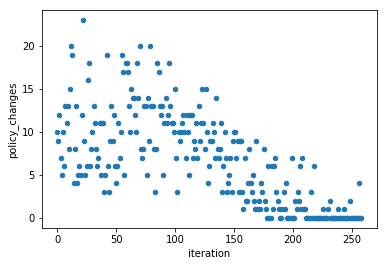

In [29]:
lake_ql_iter_df = lake_ql.iteration_data.to_dataframe()
lake_ql_iter_df.plot(x='iteration', y='policy_changes', kind='scatter', )

We can access the intermediate scoring through the scoring_summary (GeneralIterationData) and scoring_episode_statistics (EpisodeStatistics) objects

In [30]:
lake_ql_intermediate_scoring_df = lake_ql.scoring_summary.to_dataframe()
lake_ql_intermediate_scoring_df

,iteration,reward_mean,reward_median,reward_std,reward_min,reward_max,steps_mean,steps_median,steps_std,steps_min,steps_max
0,50,-1.26612,-1.25,0.180753,-1.97,-1.00,38.512,31.0,26.113021,6,101
1,100,-1.28668,-1.00,0.328476,-1.99,-1.00,80.564,101.0,25.849988,15,101
2,150,0.01388,0.42,0.821986,-1.96,0.83,61.600,55.0,27.831349,12,101
3,200,0.78064,0.80,0.145922,-1.19,0.87,23.136,22.0,7.549139,15,77
4,250,0.67704,0.81,0.497950,-1.77,0.87,23.872,21.0,13.893006,14,101


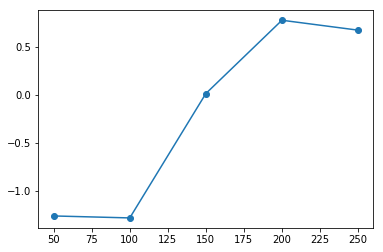

In [31]:
plt.plot(lake_ql_intermediate_scoring_df.loc[:, 'iteration'], lake_ql_intermediate_scoring_df.loc[:, 'reward_mean'], '-o')

In this case we see past ~200 iterations we're consistently getting good scores, and the solver converges shortly thereafter (no improvement over many iterations)

And if we wanted to access the actual episodes that went into one of these datapoints, they're available in a dictionary of EpisodeStatistics objects here (keyed by iteration number):

In [32]:
i = 200
print(f'EpisodeStatistics for the scoring at iter == {i}:\n')
lake_ql.scoring_episode_statistics[i].to_dataframe().head()

EpisodeStatistics for the scoring at iter == 200:



,episode_index,reward,steps,terminal,reward_mean,reward_median,reward_std,reward_min,reward_max,steps_mean,steps_median,steps_std,steps_min,steps_max,terminal_fraction
0,0,0.69,33,True,0.690000,0.69,0.000000,0.69,0.69,33.000000,33.0,0.000000,33,33,1.0
1,1,0.83,19,True,0.760000,0.76,0.070000,0.69,0.83,26.000000,26.0,7.000000,19,33,1.0
2,2,0.87,15,True,0.796667,0.83,0.077172,0.69,0.87,22.333333,19.0,7.717225,15,33,1.0
3,3,0.83,19,True,0.805000,0.83,0.068374,0.69,0.87,21.500000,19.0,6.837397,15,33,1.0
4,4,0.71,31,True,0.786000,0.83,0.072000,0.69,0.87,23.400000,19.0,7.200000,15,33,1.0
